In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import math

## Importing the drivingProfile

In [9]:
drivingProfile = pd.read_csv('./parameter.csv')

In [10]:
drivingProfile

,m,lf,lr,Cf,Cr,Iz,mu,steering_ratio,Sampling Period
0,1331,0.84,1.63,90624,90624,1500,0.5,0.0625,0.04


In [11]:
m = drivingProfile['m'][0]
lf = drivingProfile['lf'][0]
lr = drivingProfile['lr'][0]
Cf = drivingProfile['Cf'][0]
Cr = drivingProfile['Cr'][0]
Iz = drivingProfile['Iz'][0]
steering_ratio = drivingProfile['steering_ratio'][0]
Ts = drivingProfile['Sampling Period'][0]

## Importing inputs

In [12]:
inputs = pd.read_csv('./SLC_input.csv')
inputs.head()

,time,Drv_DeltaSteer,Veh_Vx
0,0.000,0.0,30.000000
1,0.005,0.0,29.999664
2,0.010,0.0,29.998813
3,0.015,0.0,29.997596
4,0.020,0.0,29.996121


In [13]:
Time = inputs['time'].to_numpy()

print(Time)
print(len(Time))

deltaSteer = inputs['Drv_DeltaSteer'].to_numpy()

print(deltaSteer)
print(len(deltaSteer))

Vx = inputs['Veh_Vx'].to_numpy()

print(Vx)
print(len(Vx))

[0.000e+00 5.000e-03 1.000e-02 ... 9.990e+00 9.995e+00 1.000e+01]
2001
[0. 0. 0. ... 0. 0. 0.]
2001
[30.         29.99966417 29.99881271 ... 22.40103788 22.39962281
 22.39820783]
2001


In [14]:
n = math.floor(Ts/(Time[1]-Time[0]))
n

8

In [15]:
time = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity = [Vx[i] for i in range(len(Vx)) if i%n==0]

## Function to calculate parameters

In [16]:
def calculate_parameters(v_x):
  A = np.array([[(-2*Cf-2*Cr)/(m*v_x), -1-((2*Cf*lf - 2*Cr*lr)/(m*v_x*v_x))], [((2*Cr*lr)-(2*Cf*lf))/Iz, (-2*Cf*lf*lf-2*Cr*lr*lr)/(Iz*v_x)]])
  B = np.array([[(2*Cf)/(m*v_x), 0], [(2*Cf*lf)/Iz, 1/Iz]])
  C = np.array([[0, 1], [(-2*Cf-2*Cr)/m, -(2*Cf*lf-2*Cr*lr)/(m*v_x)]])
  D = np.array([[0, 0], [(2*Cf)/m, 0]])

  return [A, B, C, D]

## Controller Gain K

In [17]:
K = np.array([[1.8639, -0.0279],[-542794.8896, 32604.6225]])

## Observer Gain L

In [18]:
L = np.array([[-0.000000000009229, -0.000000000131049],[0.000000000135782, 0.000000001407986]])

## Matrix P
Positive definite P such that:  
![](./Screenshot%202023-05-30%20104347.png)  
`Amin, Amax` => Discrete-time closed loop matrices derived using the system equations fror v = vmin and v = vmax respectively.

In [19]:
P = np.array([[2, 1],[1,1]])
P

array([[2, 1],
       [1, 1]])

## Evaluating the system

In [20]:
u = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x = [np.dot(np.linalg.inv(-K), u[0])]
x_cap = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y = [np.dot(C,x[0])]
y_cap = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity)):
  A, B, C, D = calculate_parameters(velocity[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y[i-1] - y_cap[i-1]

  x.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1])))
  x_cap.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1]))+np.dot(L,r))

  y.append(np.dot(out.C, x[i-1])+np.dot(out.D, u[i-1]))
  y_cap.append(np.dot(out.C, x_cap[i-1])+np.dot(out.D, u[i-1]))

  utemp = np.dot(-K, x[i])
  utemp[0][0] += steeringAngle[i]*(math.pi/180)*steering_ratio
  u.append(utemp)

## Extracting the values from the lists

### Extracting `yaw moment -> Mz` and `steering angle -> beta` from `u[]`

In [21]:
Mz = []
delta = []
for i in range(len(u)):
    Mz.append(u[i][1][0])
    delta.append(u[i][0][0])
print(len(Mz), len(delta))
print(Mz)
print(delta)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -338.89699078337793, -1137.501525584509, -2070.2958345510006, -3013.0265019261687, -3950.206082020119, -4883.052797935337, -5811.721259356526, -6735.175648854156, -6983.4046193072245, -6987.1714830972005, -6961.732095305947, -6936.670754190812, -6903.308765963714, -5548.921559875303, -3731.9558611268644, -1894.0139435084816, -96.20471062956237, 1673.3221661815055, 3426.884540156196, 5163.267712609073, 6264.906661295207, 6514.658733236362, 6502.205998803286, 6450.217104581384, 6384.017788985428, 6009.307326176256, 5227.020582680484, 4336.864162577966, 3466.9066542625283, 2625.5375151396306,

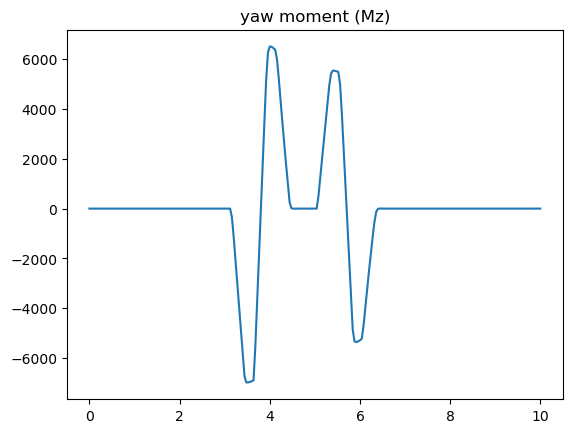

Text(0.5, 1.0, 'steering angle (delta)')

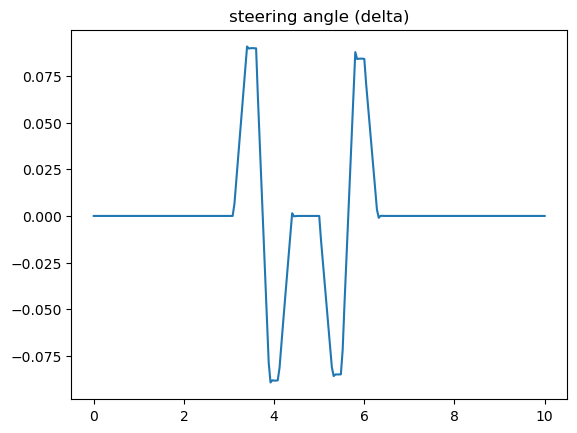

In [22]:
plt.plot(time, Mz)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time, delta)
plt.title("steering angle (delta)")

### Extracting `sideslip angle -> beta` and `yaw rate -> r` from `x[] and x_cap[]`

In [23]:
'''
0 -> beta
1 -> r
'''
r = []
beta = []

for i in range(len(x)):
    r.append(x[i][1][0])
    beta.append(x[i][0][0])

print(len(beta), len(r))
print(beta)
print(r)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006744893095260035, 0.0020455620963549417, 0.003415329385455656, 0.004757406153899388, 0.00609667625311669, 0.007441087583019784, 0.008792784862353305, 0.010153703819124405, 0.010163443783707485, 0.010133901894338153, 0.01015576721469306, 0.01019624595929677, 0.010252597023939856, 0.007560008058174041, 0.004744696007490669, 0.0019701387542949873, -0.0008388334816956048, -0.0036963936783754978, -0.0065908565979282885, -0.00951924360536623, -0.011040061453474798, -0.011059542179734176, -0.011051861788530801, -0.011114488463920871, -0.01121962891879704, -0.010613756195360098, -0.0092289284

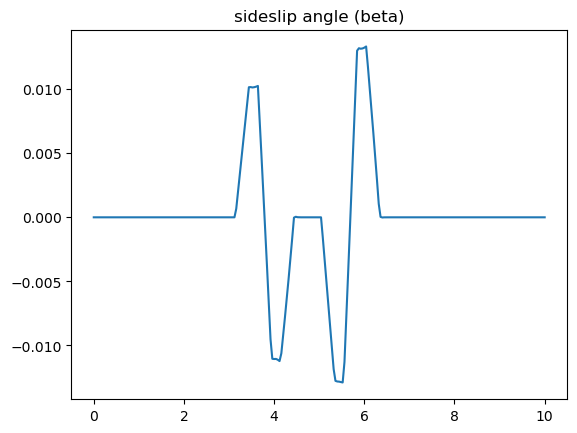

Text(0.5, 1.0, 'yaw rate (r)')

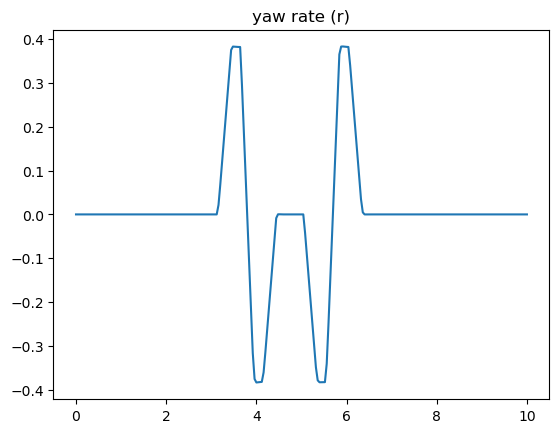

In [24]:
plt.plot(time, beta)
plt.title("sideslip angle (beta)")
plt.show()
plt.plot(time, r)
plt.title("yaw rate (r)")

In [25]:
'''
0 -> beta
1 -> r
'''
r_cap = []
beta_cap = []

for i in range(len(x)):
    r_cap.append(x_cap[i][1][0])
    beta_cap.append(x_cap[i][0][0])

print(len(beta_cap), len(r_cap))
print(beta_cap)
print(r_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006744893095260035, 0.0020455620963549417, 0.003415329385455656, 0.004757406153899388, 0.00609667625311669, 0.007441087583019784, 0.008792784862353305, 0.010153703819124405, 0.010163443783707485, 0.010133901894338153, 0.01015576721469306, 0.01019624595929677, 0.010252597023939856, 0.007560008058174041, 0.004744696007490669, 0.0019701387542949873, -0.0008388334816956048, -0.0036963936783754978, -0.0065908565979282885, -0.00951924360536623, -0.011040061453474798, -0.011059542179734176, -0.011051861788530801, -0.011114488463920871, -0.01121962891879704, -0.010613756195360098, -0.0092289284

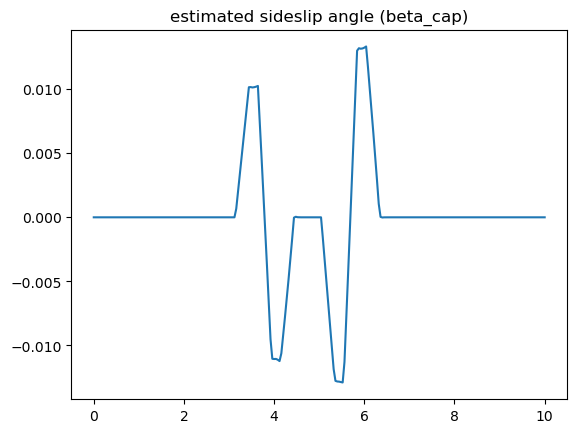

Text(0.5, 1.0, 'estaimated yaw rate (r_cap)')

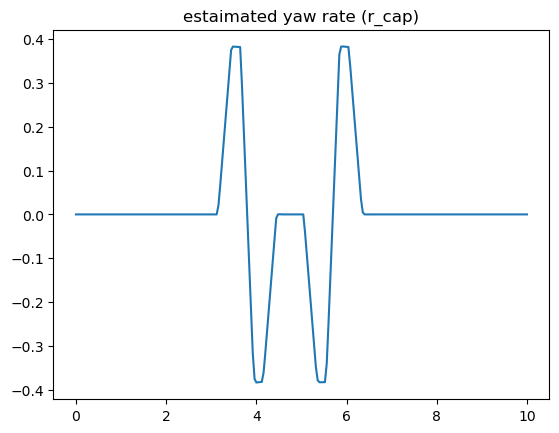

In [26]:
plt.plot(time, beta)
plt.title("estimated sideslip angle (beta_cap)")
plt.show()
plt.plot(time, r)
plt.title("estimated yaw rate (r_cap)")

### Extracting `yaw rate -> r` and `inertial acceleration -> ay` from `y[] and y_cap[]`

In [27]:
'''
0 -> r
1 -> ay
'''
r1 = []
ay = []

for i in range(len(y)):
    r1.append(y[i][0][0])
    ay.append(y[i][1][0])

print(len(r1), len(ay))
print(r1)
print(ay)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021622895375768426, 0.06894182497728456, 0.1203546880899185, 0.17161131830354262, 0.2226509690691108, 0.27364331885960314, 0.32462881445703407, 0.3756079124175379, 0.38338336736886114, 0.38300709180275616, 0.3825908623664809, 0.3824961001772601, 0.38241099205140117, 0.296045608231992, 0.19344964373374735, 0.0908888054490651, -0.011014076806446296, -0.11285840726275764, -0.2148274472307757, -0.31683435360919576, -0.37594042375774406, -0.3839247551389904, -0.38341496204053027, -0.3828630324830716, -0.3825830226777456, -0.3610040247660606, -0.31395657984856395, -0.26278935685397925, -0

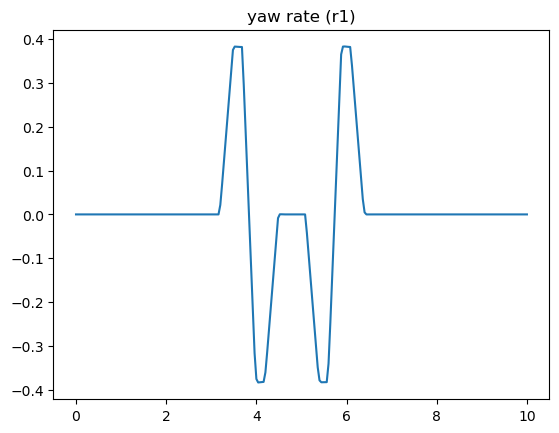

Text(0.5, 1.0, 'inertial acceleration (ay)')

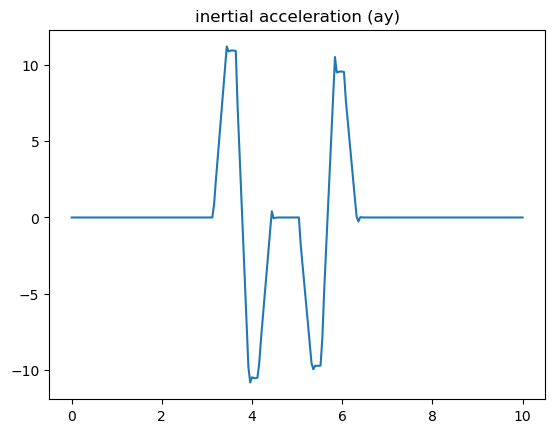

In [28]:
plt.plot(time, r1)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("inertial acceleration (ay)")

In [29]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []

for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8912587422956468, 2.481859227452582, 3.899761452290072, 5.349444770523026, 6.812798814568839, 8.276338637289205, 9.737262956884553, 11.194882724521618, 10.865803310681315, 10.921564395215642, 10.936562480045414, 10.924616622704843, 10.906456284923093, 7.316728352327922, 4.517282373752454, 1.6553052293965302, -1.231823258589701, -4.099418458532193, -6.943338785938271, -9.77100339283025, -10.800877547328415, -10.45957017795604, -10.51455316328635, -10.52007032634322, -10.490491848183204, -9.551481184600304, -7.930926381935535, -6.520086914779037, -5.0990366994441745, -3.6899437772803756, -

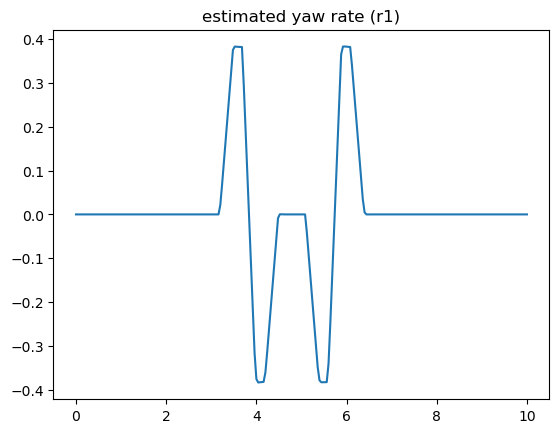

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

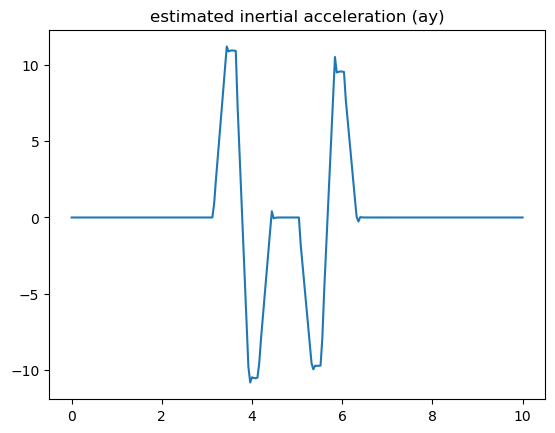

In [30]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

---

In [31]:
inputs = [[], []]

for i in range(len(u)):
    inputs[0].append(u[i][0][0])
    inputs[1].append(u[i][1][0])

inputs = np.array(inputs)

In [32]:
outputs = [[], []]

for i in range(len(y)):
    outputs[0].append(y[i][0][0])
    outputs[1].append(y[i][1][0])

outputs = np.array(outputs)

In [33]:
outputs.shape

(2, 251)

# Inserting noise to the output data

In [34]:
from sippy import functionset as fset

In [35]:
size = len(inputs[0])
noise = fset.white_noise_var(size, [0.001, 0.01])

In [36]:
noise.shape

(2, 251)

In [37]:
outputs.shape

(2, 251)

In [38]:
netOuput = outputs + noise

In [39]:
netOuput.shape

(2, 251)

---

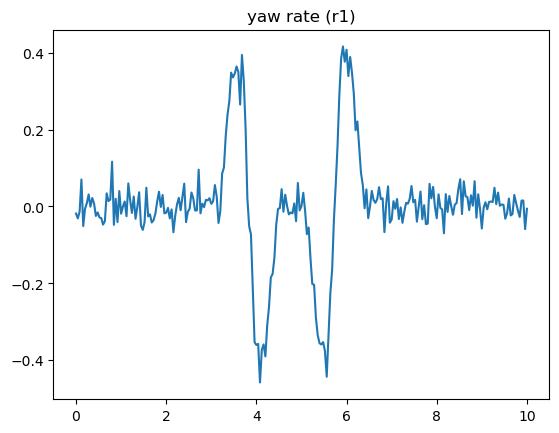

Text(0.5, 1.0, 'inertial acceleration (ay)')

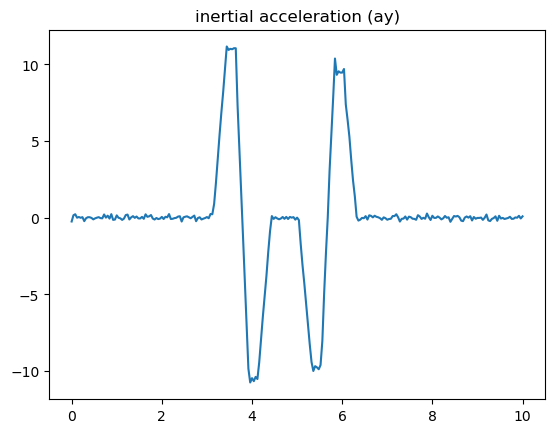

In [40]:
plt.plot(time, netOuput[0])
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, netOuput[1])
plt.title("inertial acceleration (ay)")

---
---

# SYSTEM IDENTIFICATION USING **SIPPY**

In [41]:
from sippy import system_identification
from sippy import functionset as fset
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Using input-output form

In [42]:
Id_ARMAXi = system_identification(outputs, inputs, 'ARMAX')
Id_ARMAXo = system_identification(outputs, inputs, 'ARMAX', ARMAX_mod = 'OPT')
Id_ARMAXr = system_identification(outputs, inputs, 'ARMAX', ARMAX_mod = 'RLLS')

In [43]:
# print(f"y[k] = {Id_ARMAXi.G}u[k] + {Id_ARMAXi.H}e[k]")
Id_ARMAXi.G

TransferFunction([[array([1.86154123]), array([-4.15784672e-06])], [array([144.39034357]), array([-0.00018718])]], [[array([ 1.        , -0.53534769]), array([ 1.        , -0.53534769])], [array([1.        , 0.34092529]), array([1.        , 0.34092529])]], 1.0)

In [44]:
Yout_ARMAXi = Id_ARMAXi.Yid

In [45]:
r2_score(outputs[0], Yout_ARMAXi[0])

0.9981239623397261

In [46]:
r2_score(outputs[1], Yout_ARMAXi[1])

0.9992295775292924

In [47]:
Yout_ARMAXo = Id_ARMAXo.Yid

In [48]:
r2_score(outputs[0], Yout_ARMAXo[0])

0.9981637049653704

In [49]:
r2_score(outputs[1], Yout_ARMAXo[1])

0.9999998994039605

In [50]:
Yout_ARMAXr = Id_ARMAXr.Yid

In [51]:
r2_score(outputs[0], Yout_ARMAXr[0])

0.9983813585422081

In [52]:
r2_score(outputs[1], Yout_ARMAXr[1])

0.9994046076056967

---
---
---

## Using State-Space form

In [53]:
METHOD = [
    'N4SID',
    'CVA', 
    'MOESP', 
    'PARSIM-S', 
    'PARSIM-P', 
    'PARSIM-K'
    ]

lege = ['System']

In [54]:
sysId = system_identification(netOuput, inputs, METHOD[1])

In [55]:
from sippy import functionsetSIM as fsetSIM

In [56]:
x_id, y_id = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs, sysId.x0)

In [57]:
sysId.A.shape

(20, 20)

Text(0.5, 1.0, 'yaw rate r')

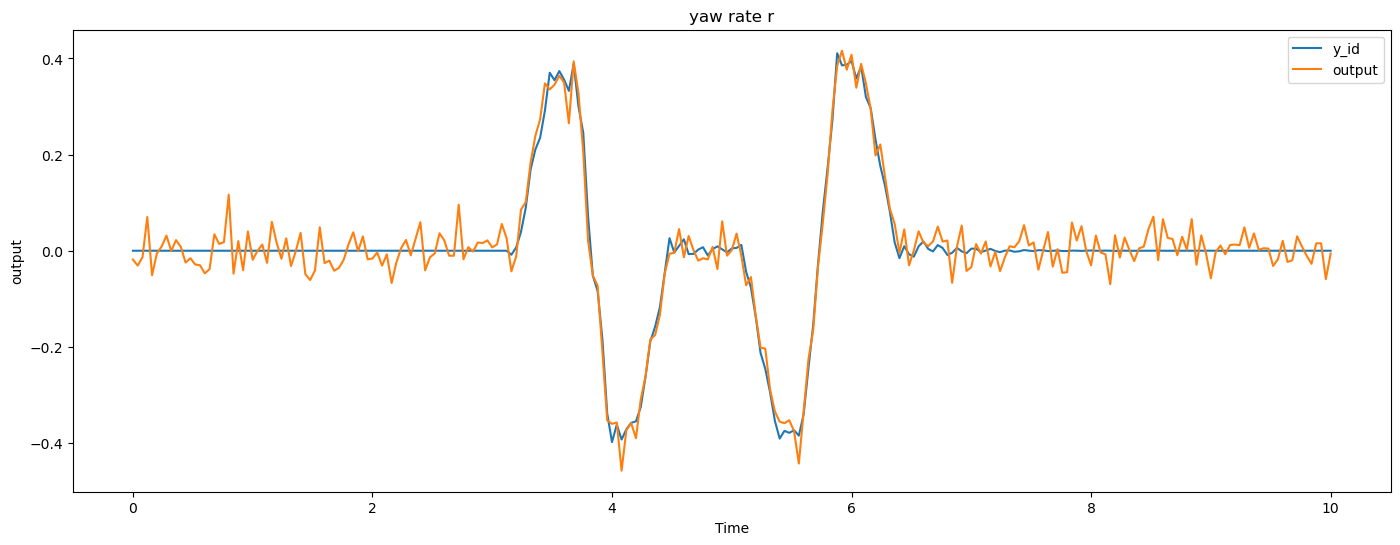

In [58]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[0], label='y_id')
plt.plot(time, netOuput[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

Text(0.5, 1.0, 'inertial acceleration ay')

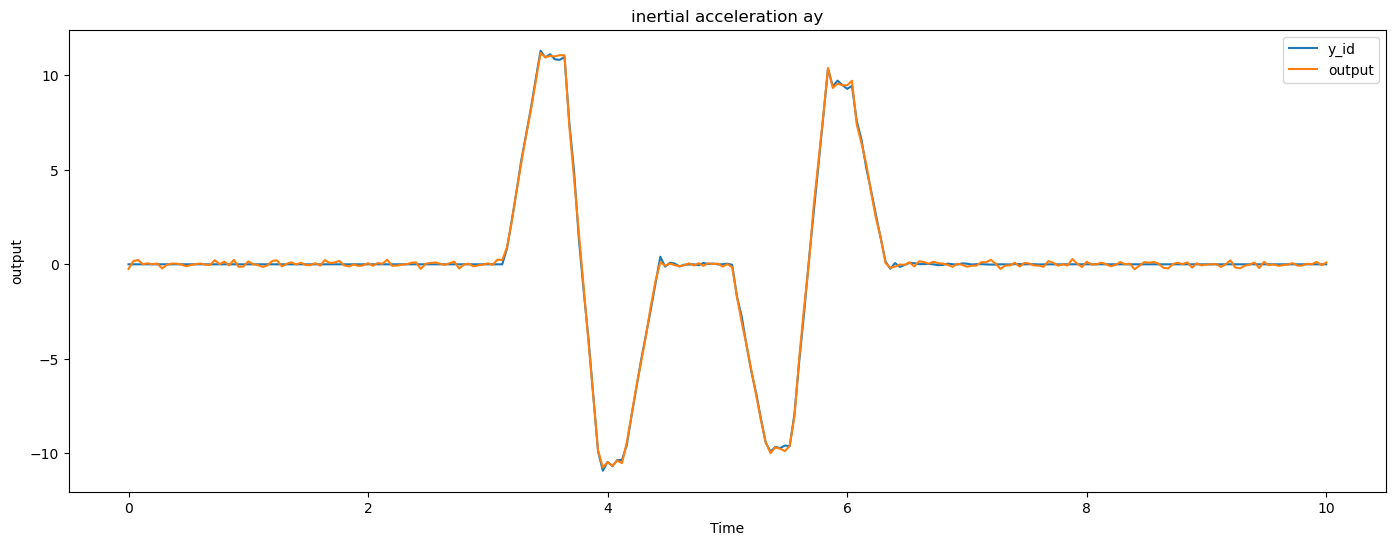

In [59]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[1], label = 'y_id')
plt.plot(time, netOuput[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [60]:
# for yaw rate
r2_score(netOuput[0], y_id[0])

0.9543002882726515

In [61]:
# for inertial acceleration ay
r2_score(netOuput[1], y_id[1])

0.9989483199774876

---

In [62]:
# for yaw rate
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.030833519201758773

In [63]:
# for inertial acceleration ay
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.030833519201758773